**Hello Fokers!**

In this Notebook Trained and Converted into the CNN Model to Tensorflow Lite Model which can easily implemented in Cloud Platforms for Classification and Detection on raw images 

A CNN model as been Derived for using the own Architecture and it convert the model using the tensorflow Model Lib

In [1]:
#import all the requirements 
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

**Checking the GPU enable for Training the Model**

In [2]:
#checking the GPU
!nvidia-smi

Fri Feb 11 08:46:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**HYPERPARAMETERS**

In [3]:
INIT_LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 100
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../input/tomatoleaf/tomato/val"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

**Spliting the Dataset**


In this Function is use for Perform the Spliting the images for training the Nerrtwork



Seed Size = 123

This will helpfull for this Dataset Spliting easily for 10 classes 

In [4]:
#spliting the Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
#dataset spliting into training and testing 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 1000 files belonging to 10 classes.


In [6]:
#checking the avaiable classes
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

10 ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


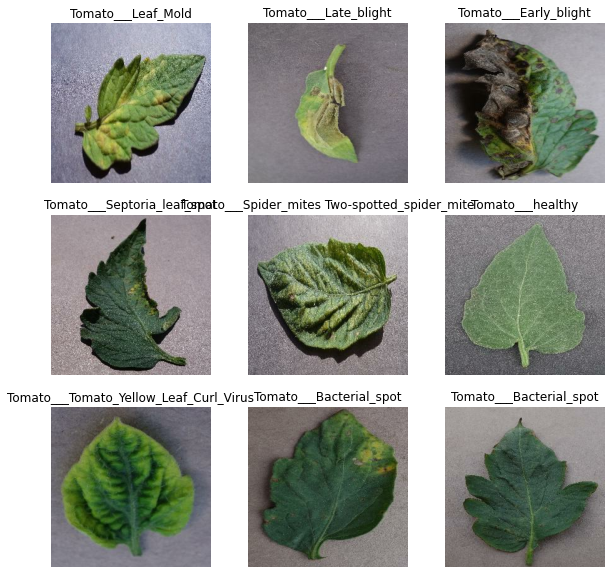

In [7]:
#Displaying the sample images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
#checking the batch Size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

**Bulid the model**

In [10]:
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**DATA AUGMENTATION**

In [11]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

**Model Architecture**

In [13]:
#CNN with softmax activation layer in last output layer
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (16, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (16, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 60, 60, 64)         

In [15]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
#Trainig the network
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
50/50 [==============================] - 12s 73ms/step - loss: 2.3047 - accuracy: 0.0864 - val_loss: 2.3015 - val_accuracy: 0.0417
Epoch 2/100
50/50 [==============================] - 1s 21ms/step - loss: 2.2897 - accuracy: 0.0897 - val_loss: 2.1813 - val_accuracy: 0.1875
Epoch 3/100
50/50 [==============================] - 1s 21ms/step - loss: 2.1710 - accuracy: 0.2041 - val_loss: 1.9177 - val_accuracy: 0.2604
Epoch 4/100
50/50 [==============================] - 1s 21ms/step - loss: 2.0584 - accuracy: 0.2212 - val_loss: 1.9139 - val_accuracy: 0.1979
Epoch 5/100
50/50 [==============================] - 1s 21ms/step - loss: 1.9436 - accuracy: 0.2716 - val_loss: 1.8818 - val_accuracy: 0.2604
Epoch 6/100
50/50 [==============================] - 1s 21ms/step - loss: 1.7956 - accuracy: 0.3691 - val_loss: 1.9743 - val_accuracy: 0.2604
Epoch 7/100
50/50 [==============================] - 1s 20ms/step - loss: 1.7911 - accuracy: 0.3402 - val_loss: 1.6881 - val_accuracy: 0.3438
Epoch

In [17]:
#testing the CNN model
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
7/7 [==============================] - 2s 8ms/step - loss: 0.6729 - accuracy: 0.8036
Test Accuracy: 80.36%


**Plotting the accuracy Graph**

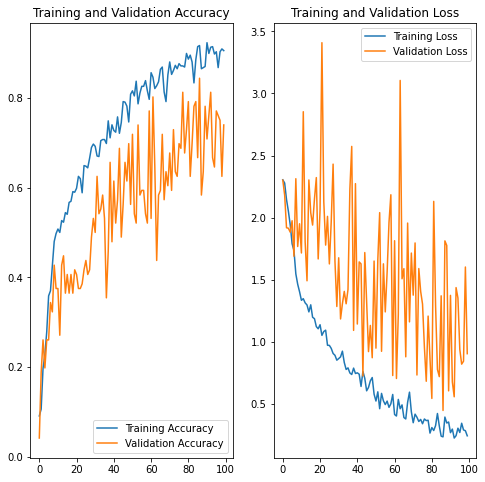

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import os
model.save("CNN.h5")

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


first image to predict
actual label: Tomato___healthy
predicted label: Tomato___healthy


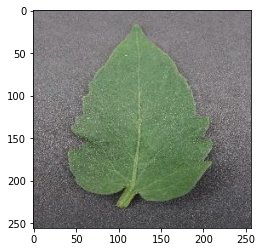

In [21]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



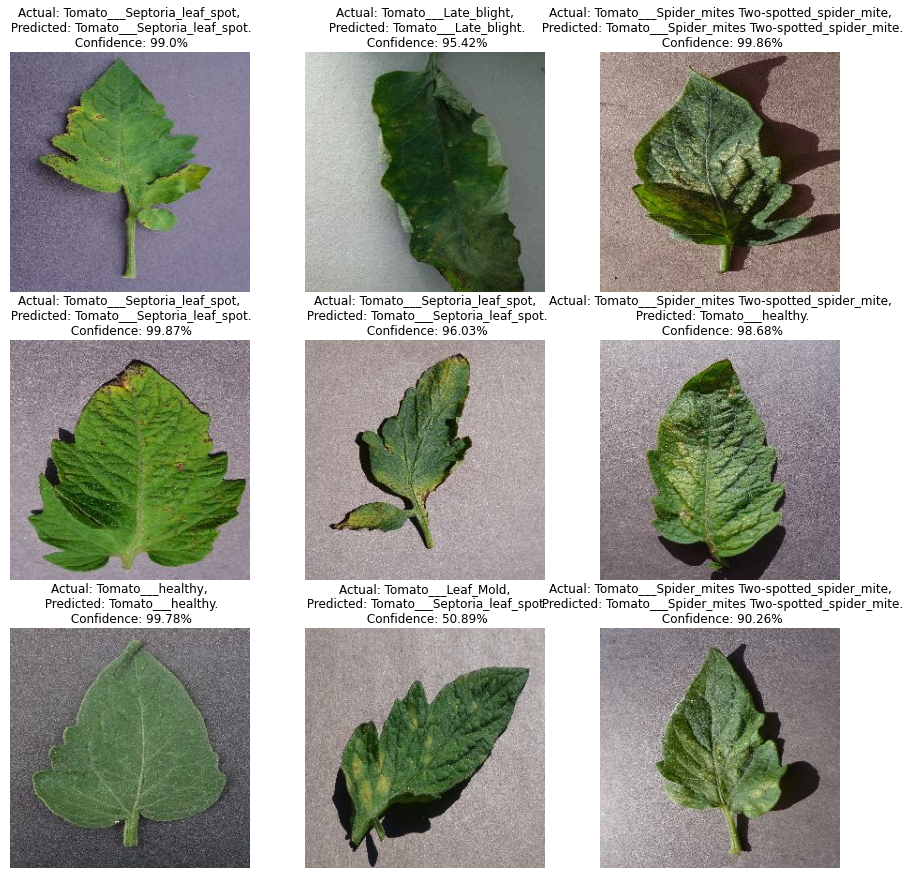

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [23]:
#Create a Quantization Aware Model
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 234 kB 4.4 MB/s eta 0:00:01


In [24]:
#Quantize only the Dense, MaxPool2D, Conv2D Layers
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [25]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 254, 254, 32)      963       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 127, 127, 32)      1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 125, 125, 64)      18627     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 62, 62, 64)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 60, 60, 64)       

In [26]:
#Finr Tuning the model

quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [27]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
50/50 [==============================] - 4s 43ms/step - loss: 0.4079 - accuracy: 0.8465 - val_loss: 0.7568 - val_accuracy: 0.7396
Epoch 2/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2425 - accuracy: 0.9249 - val_loss: 0.6016 - val_accuracy: 0.7917
Epoch 3/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2961 - accuracy: 0.8977 - val_loss: 0.5242 - val_accuracy: 0.8229
Epoch 4/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2536 - accuracy: 0.9160 - val_loss: 1.0787 - val_accuracy: 0.6667
Epoch 5/25
50/50 [==============================] - 2s 39ms/step - loss: 0.3055 - accuracy: 0.9039 - val_loss: 0.6427 - val_accuracy: 0.7500
Epoch 6/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2233 - accuracy: 0.9218 - val_loss: 0.6204 - val_accuracy: 0.8229
Epoch 7/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2751 - accuracy: 0.8958 - val_loss: 0.6757 - val_accuracy: 0.7708
Epoch 8/25
50

In [28]:
#Testing the accuracy after Fine tunning 
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
7/7 [==============================] - 0s 12ms/step - loss: 0.6541 - accuracy: 0.8125
Test Accuracy: 81.25%


In [29]:
#saving the fine tunning modeol
import os
model.save("FineTuning.h5")

**Convert Quanitzation Aware Model to TF Lite Model**

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [31]:
#Testing the Tfmodel


# I tried to convert FINETUNE WEIGHTS into TFLITE  model its take about 3 hour to runned but still running in kaggle.If you want to convert the model.Please move to Google colab Platform 
#No chances in the code to convert tflite model

def evaluate_tflite_model (dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Quant TFLite test_accuracy: 0.799


In [32]:
import os
model.save("tflite_model.pb")

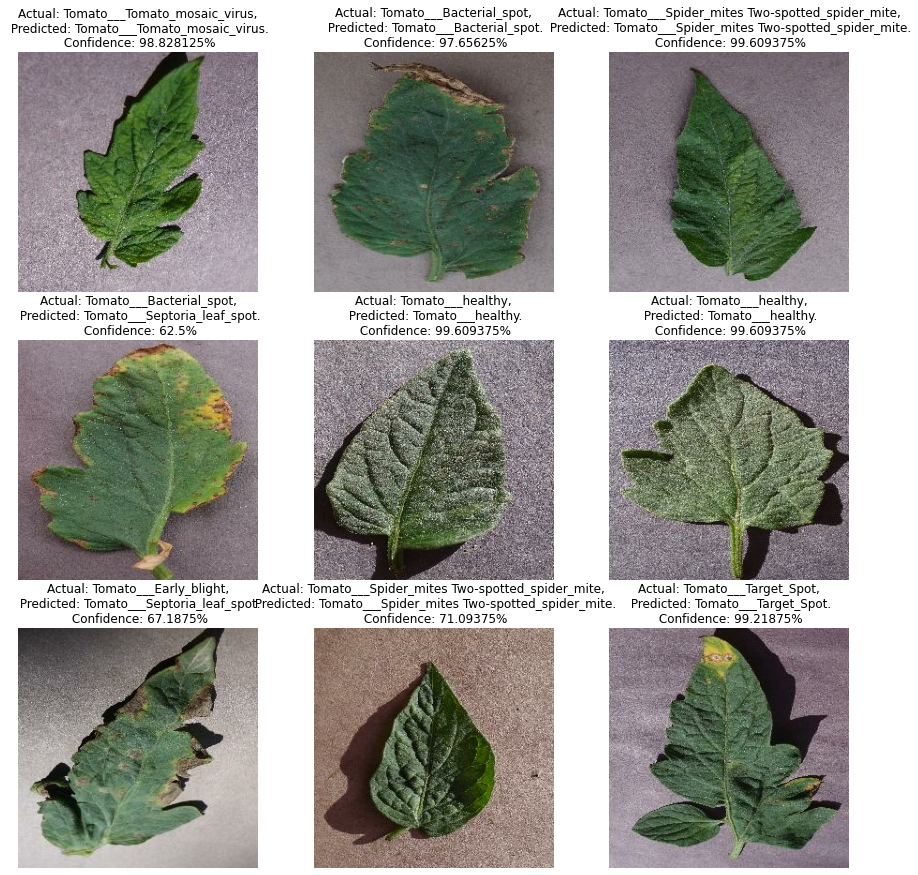

In [33]:
#testing the tflite model 
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

